In [45]:
import glob
import json
import cv2
import numpy as np
from typing import List
import torch
import sys
from torchreid.utils import FeatureExtractor
from dataclasses import dataclass
from pathlib import Path
from zipfile import ZipFile
import shutil
from itertools import groupby
import matplotlib.pyplot as plt 

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'1.9.0'

In [4]:
extractor = FeatureExtractor(
    model_name='osnet_x1_0',
    model_path='/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x1_0_imagenet.pth',
    device='cuda'
)

Successfully loaded imagenet pretrained weights from "/home/eam/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


/home/eam/anaconda3/envs/alphapose_yolo4/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [51]:
def read_calib_file(filepath):
    """
    Read in a calibration file and parse into a dictionary.
    Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
    """
    data = {}
    with open(filepath, 'r') as f:
        for line in f.readlines():
            line = line.rstrip()
            if len(line) == 0: continue
            key, value = line.split(':', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data

def load_velo_scan(velo_filename):
    scan = np.fromfile(velo_filename, dtype=np.float32)
    scan = scan.reshape((-1, 4))
    return scan

def project_velo_to_cam2(calib):
    P_velo2cam_ref = np.vstack((calib['Tr_velo_to_cam'].reshape(3, 4), np.array([0., 0., 0., 1.])))  # velo2ref_cam
    R_ref2rect = np.eye(4)
    R0_rect = calib['R0_rect'].reshape(3, 3)  # ref_cam2rect
    R_ref2rect[:3, :3] = R0_rect
    P_rect2cam2 = calib['P2'].reshape((3, 4))
    proj_mat = P_rect2cam2 @ R_ref2rect @ P_velo2cam_ref
    return proj_mat

def project_to_image(points, proj_mat):
    """
    Apply the perspective projection
    Args:
        pts_3d:     3D points in camera coordinate [3, npoints]
        proj_mat:   Projection matrix [3, 4]
    """
    num_pts = points.shape[1]

    # Change to homogenous coordinate
    points = np.vstack((points, np.ones((1, num_pts))))
    points = proj_mat @ points
    points[:2, :] /= points[2, :]
    return points[:2, :]

def prepare_lidar(pts_velo, calib, img_width, img_height):
    # projection matrix (project from velo2cam2)
    proj_velo2cam2 = project_velo_to_cam2(calib)

    # apply projection
    pts_2d = project_to_image(pts_velo.transpose(), proj_velo2cam2)
    #print(pts_2d.shape, pts_velo.shape, proj_velo2cam2.shape)

    # Filter lidar points to be within image FOV
    inds = np.where((pts_2d[0, :] < img_width) & (pts_2d[0, :] >= 0) &
                    (pts_2d[1, :] < img_height) & (pts_2d[1, :] >= 0) &
                    (pts_velo[:, 0] > 0)
                    )[0]

    # Filter out pixels points
    imgfov_pc_pixel = pts_2d[:, inds]

    # Retrieve depth from lidar
    imgfov_pc_velo = pts_velo[inds, :]
    imgfov_pc_velo = np.hstack((imgfov_pc_velo, np.ones((imgfov_pc_velo.shape[0], 1))))
    imgfov_pc_cam2 = proj_velo2cam2 @ imgfov_pc_velo.transpose()
    
    return imgfov_pc_pixel, imgfov_pc_cam2



In [52]:
def project_to_upper_bodies(pc_pixel, pc_cam2, upper_body):
    
    imgfov_pc_pixel = pc_pixel
    imgfov_pc_cam2 = pc_cam2

    
    lidars = np.zeros(shape=(3, 1))
    
    np_upper_body = np.array(upper_body).reshape(1, 4).flatten()

    upper_left = np_upper_body[0:2]
    lower_right = np_upper_body[0:2] + np_upper_body[2:4]

    box_indices = np.where((imgfov_pc_pixel[0, :] > upper_left[0]) & (imgfov_pc_pixel[0, :] < lower_right[0])&
                          (imgfov_pc_pixel[1, :] > upper_left[1])&(imgfov_pc_pixel[1, :] < lower_right[1]))[0]

    projected_points = imgfov_pc_pixel[0:2, box_indices]
    lidars = np.append(projected_points, imgfov_pc_cam2[2:3, box_indices], axis=0)
        
    return lidars

In [53]:
@dataclass
class ObjectModel:
    bbox : List[int]
    upper : List[int]
    features : List[float]
    lidars: List[List[float]]

@dataclass
class ImageModel:
    img_name:str
    objects:List[ObjectModel]

In [65]:
def get_upper_body_rectangle(bbox: List[int], sub_bbox_ratio):
    """
    convert bbox yo in:
    [x, y, width, height]
    """
    sub_width = int(bbox[2] * sub_bbox_ratio)
    sub_height = int(bbox[3] * sub_bbox_ratio)
    return np.array([int(bbox[0]+(bbox[2]/2) - (sub_width/2)), int(bbox[1]+(bbox[3]/5)), sub_width, sub_height])

In [68]:
def crop(img, bboxes):
    cropped_imgs = []
    for bbox in bboxes:
        bbox = [int(round(x)) for x in bbox]
        cropped = img[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
        cropped_imgs.append(cropped)
    return cropped_imgs

In [69]:
sub_dataset = "0000"
sub_bbox_ratio = 1/4

In [75]:
for ds_index in range(21):
    sub_dataset = f'{ds_index:04d}'
    print(f'working on dataset {sub_dataset}')
    # delete all previous extracted lidar files and load the one corresponding to the sub_dataset
    lidar_zip_file = "/home/eam/KittiDs/data_tracking_velodyne.zip"
    base_folder = "training/velodyne/"
    extract_lidar_folder = "/home/eam/KittiDs/tmp"
    shutil.rmtree(extract_lidar_folder)

    with ZipFile(lidar_zip_file, 'r') as zipObj:
        files = zipObj.namelist()
        for file in files:
            if file.startswith(base_folder+sub_dataset):
                zipObj.extract(file, extract_lidar_folder)



    # load keypoint detection file containing keypoints, bbox and each keypoints score            
    kp_detections = open(f"/home/eam/MasterThesis/Thesis/deep-sort3d/res/alphapose-results-yolo4-kitti-train-{sub_dataset}.json", 'r')
    content  = kp_detections.read()
    detections = json.loads(content)

    # load the images path corresponding to the sub_dataset
    imgs = glob.glob(f"/home/eam/KittiDs/data_tracking_image_2/training/image_02/{sub_dataset}/*.png")
    imgs = sorted(imgs)

    # load the calib file corresponding to the sub_dataset
    calib = read_calib_file(f'/home/eam/KittiDs/data_tracking_calib/training/calib/{sub_dataset}.txt')

    # load the lidar-point file corresponding to the sub_dataset
    velodyne_pah = f"{extract_lidar_folder}/training/velodyne/{sub_dataset}"
    velo_path = Path(velodyne_pah)
    velo_frames = velo_path.glob("*.bin")
    velo_frames = [str(x) for x in sorted(velo_frames)]



    grouped_detections = [list(v) for l,v in groupby(sorted(detections, key=lambda x:x["image_id"]), lambda x: x["image_id"])]


    images_info = []
    cnt = 0
    for detection in grouped_detections:
        if len(detection) > 0:
            img_name = detection[0]["image_id"]
            img_path = [x for x in imgs if img_name in x][0]
            frame = cv2.imread(img_path)

            height, width, channel = frame.shape
            velo_points = load_velo_scan(velo_frames[cnt])[:, :3]
            imgfov_pc_pixel, imgfov_pc_cam2 = prepare_lidar(velo_points, calib, width, height)
            cnt+=1

            objects_info = []
            for obj in detection:
                #print(obj)
                if obj["score"] > 1.5:
                    bbox = [int(x) for x in obj["box"]] 
                    upper_body = get_upper_body_rectangle(bbox, sub_bbox_ratio)
#                     upper_body = [int(round(x)) for x in upper_points2bbox(upper_body)]
                    cropped_obj = crop(frame, [bbox])[0]
                    cropped_obj = cv2.cvtColor(cropped_obj, cv2.COLOR_BGR2RGB)
                    features = extractor(cropped_obj)
                    lidars = project_to_upper_bodies(imgfov_pc_pixel, imgfov_pc_cam2, upper_body)
                    np_features = features.squeeze().cpu().detach().numpy().astype(float)
                    obj_model = ObjectModel(bbox, upper_body.tolist(), np.round(np_features,6).tolist(), np.round(lidars,2).tolist())
                    objects_info.append(obj_model.__dict__)
            img_model = ImageModel(img_name, objects_info)
            images_info.append(img_model.__dict__)
    json_images_info = json.dumps(images_info, indent=4,)
    with open(f"dataset_final_train_{sub_dataset}.json", "w") as f:
        f.write(json_images_info)

working on dataset 0000
working on dataset 0001
working on dataset 0002
working on dataset 0003
working on dataset 0004
working on dataset 0005
working on dataset 0006
working on dataset 0007
working on dataset 0008
working on dataset 0009
working on dataset 0010
working on dataset 0011
working on dataset 0012
working on dataset 0013
working on dataset 0014
working on dataset 0015
working on dataset 0016
working on dataset 0017
working on dataset 0018
working on dataset 0019
working on dataset 0020


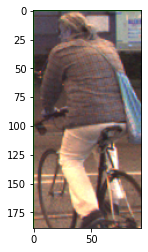

<function __main__.crop(img, bboxes)>

In [60]:
tmp_img = cv2.imread("/home/eam/KittiDs/data_tracking_image_2/training/image_02/0000/000000.png")
tmp_img = cv2.rectangle(tmp_img, (778, 169), (778+94, 169+189), (0,255,0), 1)
tmp_img = crop(tmp_img,[[778, 169, 94, 189]])[0]
plt.imshow(tmp_img)
plt.show()
crop

[836 253]


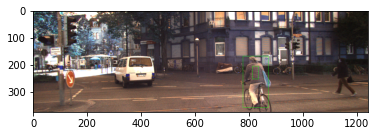

In [67]:
sub_upper = get_upper_body_rectangle([778, 169, 94, 189], 1/4)
print(sub_upper[0:2] + sub_upper[2:4])
tmp_img = cv2.imread("/home/eam/KittiDs/data_tracking_image_2/training/image_02/0000/000000.png")
tmp_img = cv2.rectangle(tmp_img, (778, 169), (778+94, 169+189), (0,255,0), 1)
tmp_img = cv2.rectangle(tmp_img, sub_upper[0:2], sub_upper[0:2] + sub_upper[2:4], (0,255,0), 1)
plt.imshow(tmp_img)
plt.show()